Мохляков П.А. \
М8О-408Б-19 \
Вариант 4

## Лабораторная работа 7

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import tqdm
import pickle
from pathlib import Path
import random
import copy

Функция вывода картинки

In [6]:
def image_show(image, ax=None):
    image = copy.deepcopy(image)
    image += 1
    image /= 2
    if ax is None:
        plt.imshow(image.reshape((32,32,3)))
    else:
        ax.imshow(image.reshape((32,32,3)))

Готовим датасет

In [7]:
dataset = []
for i in range(1, 6):
    pickle_data = pickle.loads(Path(f'cifar-10-batches-py/data_batch_{i}').read_bytes(), encoding='latin1')
    labels = pickle_data['labels']
    data = pickle_data['data']
    require_label = 4
    for label, image in zip(labels, data):
        if label == require_label:
            image = (image - 127.5) / 127.5
            image = np.array(image.reshape((3,32,32)).transpose([1,2,0]), dtype=np.float32).flatten()
            dataset.append((image, image))

In [8]:
train_dataloader = DataLoader(dataset, shuffle=True, batch_size=256)

Модель

In [9]:
image_size = 32*32*3
encoder = nn.Sequential(
    nn.Linear(image_size, image_size*2),
    nn.ReLU(),
    nn.Linear(image_size*2, image_size//8),
)
decoder = nn.Sequential(
    nn.Linear(image_size//8, image_size),
    nn.ReLU(),
    nn.Linear(image_size, image_size),
    nn.Tanh()
)

Тренеруем

In [10]:
optimizer_encoder = torch.optim.Adam(encoder.parameters(), lr=1e-3)
optimizer_decoder = torch.optim.Adam(decoder.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epoch = 100
encoder.train()
decoder.train()

loses = []

for ep in tqdm.tqdm(range(epoch)):
    epoch_loss = []
    for (inp, out) in train_dataloader:
        
        inp = inp.to(torch.float32)
        out = out.to(torch.float32)
        pred_encoder = encoder(inp)
        pred_decoder = decoder(pred_encoder)
        
        loss = loss_fn(pred_decoder, out)
        loss = torch.sqrt_(loss)
        epoch_loss.append(loss.item())
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        loss.backward()
        optimizer_encoder.step()
        optimizer_decoder.step()
    loses.append(np.mean(epoch_loss))


100%|██████████| 100/100 [13:27<00:00,  8.07s/it]


Ошибка

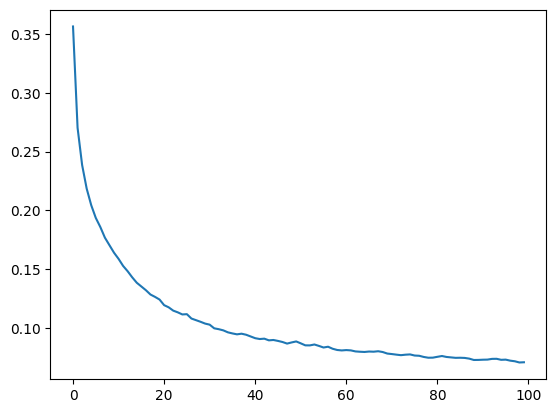

In [11]:
plt.plot(loses)

Картинка на входе

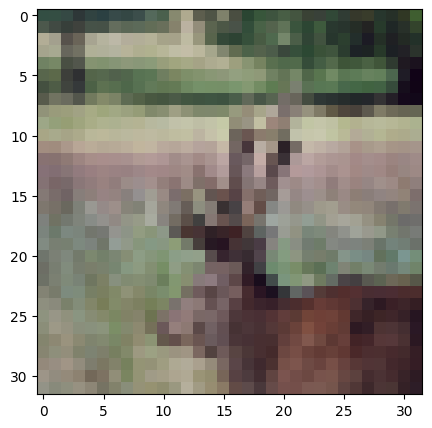

In [70]:
encoder.eval()
decoder.eval()
image_num = random.randint(0, len(dataset) - 1)
image_show(dataset[image_num][0])


Картинка на выходе и она же с шумом

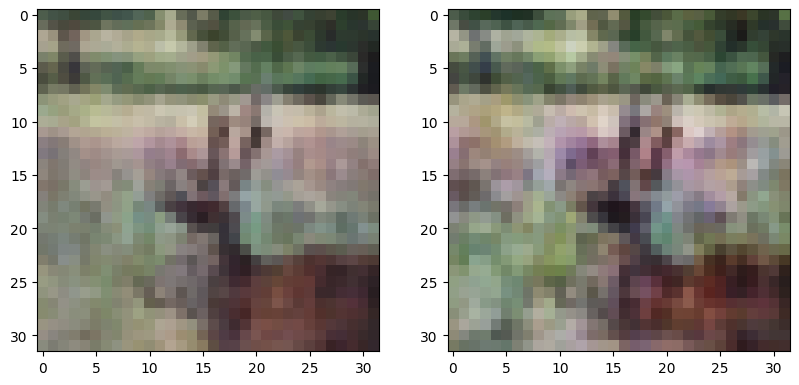

In [71]:
enc = encoder(torch.flatten(torch.Tensor(dataset[image_num][0])))
dec = decoder(enc)
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax_1 = fig.add_subplot(1,3,1)
ax_2 = fig.add_subplot(1,3,2)
image_show(dec.detach().numpy().reshape((32,32,3)), ax_1)
enc_noise = enc.detach().numpy() + np.random.rand(384) - np.random.rand(384)
dec_noise = decoder(torch.Tensor(enc_noise))
image_show(dec_noise.detach().numpy().reshape((32,32,3)), ax_2)